In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import cPickle as pickle
import time
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from engine.simulator import FleetSimulator
from engine.lp import Agent
import experiment as ex
plt.style.use('ggplot')

In [2]:
GRAPH_PATH = 'data/pickle/nyc_network_graph.pkl'
TRIP_PATH = 'data/nyc_taxi/trips_2016-05.csv'
DEMAND_MODEL_PATH = 'data/pickle/demand_predictor.pkl'
ETA_MODEL_PATH = 'data/pickle/triptime_predictor.pkl'
GEOHASH_TABLE_PATH = 'data/table/zones.csv'
ETA_TABLE_PATH = 'data/table/eta.csv'
PDEST_TABLE_PATH = 'data/table/pdest.csv'
SCORE_PATH = 'data/results/score_lp.csv'

SAMPLE_SIZE = 500000
NUM_FLEETS = 8000
NO_OP_STEPS = 1
CYCLE = 15

In [3]:
def plot(result):
    plt.figure(figsize=(10, 6))
    index = result.index * 15.0 / 60
    plt.subplot(211)
    plt.ylabel('count')
    plt.plot(index, result.requests/10, label='demand/10')
    plt.plot(index, result.reject, label='reject')
    plt.plot(index, result.resource/10, label='resource/10')
    plt.legend()
    plt.subplot(212)
    plt.ylabel('wait/idle time')
    plt.plot(index, result.wait_time/(result.requests-result.reject), label='wait')
    plt.plot(index, result.idle_trip/NUM_FLEETS, label='idle')
    plt.legend()
    return plt

In [4]:
with open(GRAPH_PATH, 'r') as f:
    G = pickle.load(f)
with open(ETA_MODEL_PATH, 'r') as f:
    eta_model = pickle.load(f)
# with open(DEMAND_MODEL_PATH, 'r') as f:
#     demand_model = pickle.load(f)

geohash_table = pd.read_csv(GEOHASH_TABLE_PATH, index_col='geohash')
eta_table = pd.read_csv(ETA_TABLE_PATH, index_col=['dayofweek', 'hour', 'pickup_zone'])
pdest_table = pd.read_csv(PDEST_TABLE_PATH, index_col=['dayofweek', 'hour', 'pickup_zone'])

In [5]:
trips, dayofweek, minofday, duration = ex.load_trips(TRIP_PATH, SAMPLE_SIZE)
env = FleetSimulator(G, eta_model, CYCLE, CYCLE)
num_steps = 1440 / CYCLE

## No Dispatch

In [6]:
%%time
env.reset(NUM_FLEETS, trips, dayofweek, minofday)    
for _ in range(NO_OP_STEPS):
    _, requests, _, _, _ = env.step()
score = ex.run(env, None, num_steps, average_cycle=4)
ex.describe(score)

t = 60 (12 elapsed) // REQ: 26430 / REJ: 2881 / AWT: 4.5 / DSP: 0.00 / RWD: 76.8
t = 120 (21 elapsed) // REQ: 23090 / REJ: 4489 / AWT: 5.4 / DSP: 0.00 / RWD: 33.5
t = 180 (29 elapsed) // REQ: 18750 / REJ: 3772 / AWT: 5.6 / DSP: 0.00 / RWD: 25.2
t = 240 (35 elapsed) // REQ: 14495 / REJ: 3250 / AWT: 5.7 / DSP: 0.00 / RWD: 18.3
t = 300 (40 elapsed) // REQ: 7418 / REJ: 363 / AWT: 4.2 / DSP: 0.00 / RWD: 10.6
t = 360 (44 elapsed) // REQ: 3905 / REJ: 550 / AWT: 6.2 / DSP: 0.00 / RWD: 6.6
t = 420 (48 elapsed) // REQ: 4701 / REJ: 909 / AWT: 6.7 / DSP: 0.00 / RWD: 7.5
t = 480 (54 elapsed) // REQ: 6594 / REJ: 2021 / AWT: 7.3 / DSP: 0.00 / RWD: 10.1
t = 540 (61 elapsed) // REQ: 9905 / REJ: 3394 / AWT: 6.8 / DSP: 0.00 / RWD: 14.9
t = 600 (70 elapsed) // REQ: 14705 / REJ: 5560 / AWT: 5.8 / DSP: 0.00 / RWD: 20.4
t = 660 (80 elapsed) // REQ: 19635 / REJ: 6862 / AWT: 4.8 / DSP: 0.00 / RWD: 26.7
t = 720 (89 elapsed) // REQ: 22605 / REJ: 7694 / AWT: 4.5 / DSP: 0.00 / RWD: 31.3
t = 780 (100 elapsed) // RE

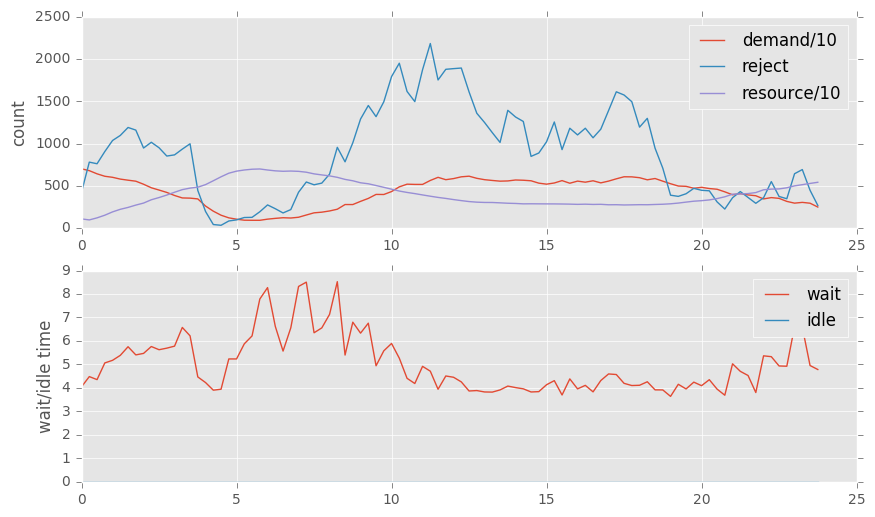

In [20]:
plot(score);

## Demand Greedy

In [29]:
from engine.greedy import gAgent

env.reset(NUM_FLEETS, trips, dayofweek, minofday)

agent = gAgent(geohash_table, eta_table, demand_model, CYCLE)
for _ in range(NO_OP_STEPS):
    _, requests, _, _, _ = env.step()
agent.reset(requests, env.dayofweek, env.minofday)
score = ex.run(env, agent, num_steps, average_cycle=4)
ex.describe(score)

t = 60 (111 elapsed) // REQ: 26430 / REJ: 2555 / AWT: 4.4 / DSP: 0.17 / RWD: 76.2
t = 120 (314 elapsed) // REQ: 23090 / REJ: 2873 / AWT: 5.4 / DSP: 0.38 / RWD: 33.0
t = 180 (560 elapsed) // REQ: 18750 / REJ: 588 / AWT: 5.3 / DSP: 0.54 / RWD: 26.1
t = 240 (809 elapsed) // REQ: 14495 / REJ: 0 / AWT: 3.5 / DSP: 0.74 / RWD: 17.5
t = 300 (981 elapsed) // REQ: 7418 / REJ: 0 / AWT: 1.4 / DSP: 0.74 / RWD: 3.7
t = 360 (1053 elapsed) // REQ: 3905 / REJ: 0 / AWT: 1.5 / DSP: 0.33 / RWD: 4.6
t = 420 (1119 elapsed) // REQ: 4701 / REJ: 26 / AWT: 1.9 / DSP: 0.18 / RWD: 8.1
t = 480 (1196 elapsed) // REQ: 6594 / REJ: 149 / AWT: 2.1 / DSP: 0.21 / RWD: 12.6
t = 540 (1269 elapsed) // REQ: 9905 / REJ: 0 / AWT: 3.0 / DSP: 0.21 / RWD: 20.1
t = 600 (1342 elapsed) // REQ: 14705 / REJ: 1 / AWT: 3.1 / DSP: 0.16 / RWD: 30.2
t = 660 (1402 elapsed) // REQ: 19635 / REJ: 464 / AWT: 3.5 / DSP: 0.10 / RWD: 38.0
t = 720 (1451 elapsed) // REQ: 22605 / REJ: 1592 / AWT: 3.6 / DSP: 0.07 / RWD: 42.5
t = 780 (1491 elapsed) // 

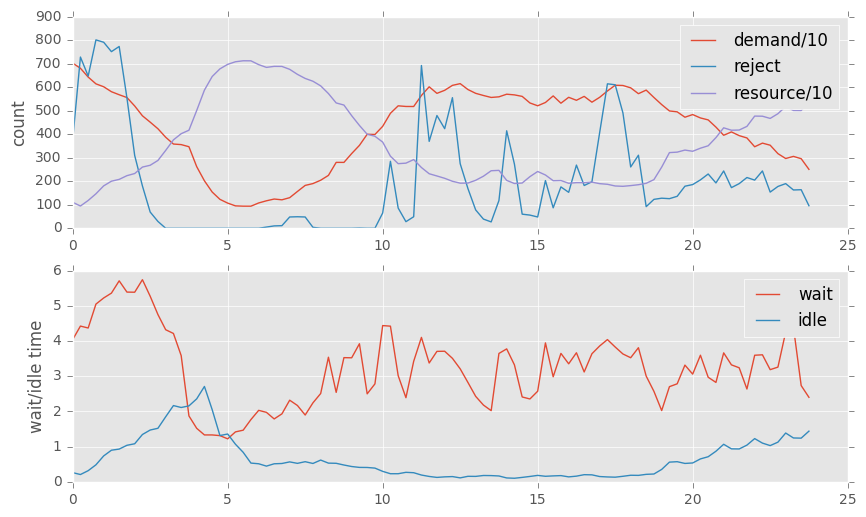

In [30]:
plot(score);

In [22]:
env.reset(NUM_FLEETS, trips, dayofweek, minofday)

agent = Agent(geohash_table, eta_table, pdest_table, demand_model, CYCLE,
              T=3, cost=0, penalty=20.0)
for _ in range(NO_OP_STEPS):ii
    _, requests, _, _, _ = env.step()
agent.reset(requests, env.dayofweek, env.minofday)
score = ex.run(env, agent, num_steps, average_cycle=4)
ex.describe(score)

t = 60 (315 elapsed) // REQ: 26430 / REJ: 2143 / AWT: 4.4 / DSP: 0.40 / RWD: 74.8
t = 120 (646 elapsed) // REQ: 23090 / REJ: 1301 / AWT: 5.4 / DSP: 0.64 / RWD: 33.7
t = 180 (969 elapsed) // REQ: 18750 / REJ: 17 / AWT: 4.1 / DSP: 0.73 / RWD: 25.8
t = 240 (1211 elapsed) // REQ: 14495 / REJ: 0 / AWT: 3.3 / DSP: 0.61 / RWD: 19.6
t = 300 (1446 elapsed) // REQ: 7418 / REJ: 0 / AWT: 1.6 / DSP: 0.34 / RWD: 8.3
t = 360 (1581 elapsed) // REQ: 3905 / REJ: 0 / AWT: 1.8 / DSP: 0.11 / RWD: 7.3
t = 420 (1733 elapsed) // REQ: 4701 / REJ: 1 / AWT: 2.3 / DSP: 0.14 / RWD: 8.6
t = 480 (1924 elapsed) // REQ: 6594 / REJ: 54 / AWT: 2.7 / DSP: 0.22 / RWD: 12.4
t = 540 (2162 elapsed) // REQ: 9905 / REJ: 0 / AWT: 3.0 / DSP: 0.31 / RWD: 18.4
t = 600 (2489 elapsed) // REQ: 14705 / REJ: 23 / AWT: 3.2 / DSP: 0.40 / RWD: 26.7
t = 660 (2835 elapsed) // REQ: 19635 / REJ: 0 / AWT: 2.4 / DSP: 0.44 / RWD: 35.6
t = 720 (3062 elapsed) // REQ: 22605 / REJ: 33 / AWT: 2.4 / DSP: 0.38 / RWD: 43.2
t = 780 (3265 elapsed) // REQ:

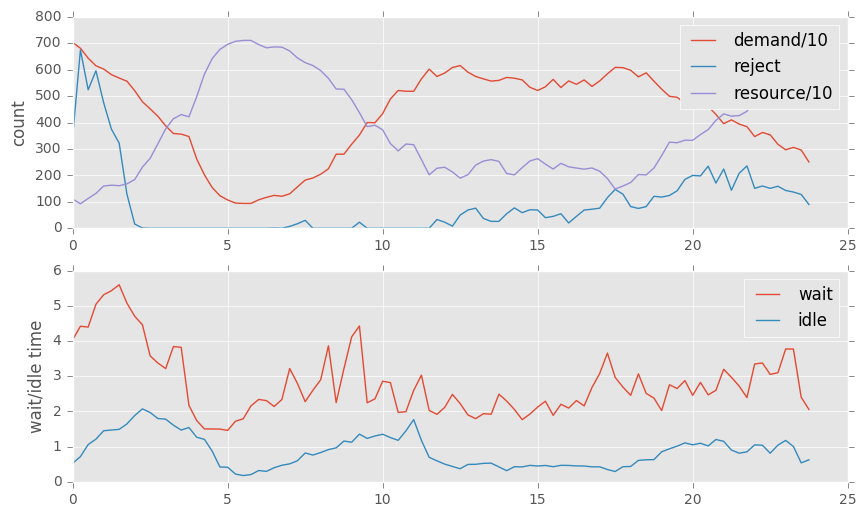

In [26]:
plot(score);

In [6]:
env.reset(NUM_FLEETS, trips, dayofweek, minofday)

agent = Agent(geohash_table, eta_table, pdest_table, demand_model, CYCLE,
              T=3, cost=0, penalty=25.0)
for _ in range(NO_OP_STEPS):
    _, requests, _, _, _ = env.step()
agent.reset(requests, env.dayofweek, env.minofday)
score = ex.run(env, agent, num_steps, average_cycle=4)
ex.describe(score)

t = 60 (253 elapsed) // REQ: 26430 / REJ: 2143 / AWT: 4.4 / DSP: 0.40 / RWD: 74.7
t = 120 (582 elapsed) // REQ: 23090 / REJ: 1264 / AWT: 5.3 / DSP: 0.65 / RWD: 33.6
t = 180 (888 elapsed) // REQ: 18750 / REJ: 10 / AWT: 4.0 / DSP: 0.74 / RWD: 25.8
t = 240 (1130 elapsed) // REQ: 14495 / REJ: 0 / AWT: 3.2 / DSP: 0.62 / RWD: 19.6
t = 300 (1305 elapsed) // REQ: 7418 / REJ: 0 / AWT: 1.6 / DSP: 0.35 / RWD: 8.2
t = 360 (1439 elapsed) // REQ: 3905 / REJ: 0 / AWT: 1.8 / DSP: 0.11 / RWD: 7.3
t = 420 (1582 elapsed) // REQ: 4701 / REJ: 3 / AWT: 2.3 / DSP: 0.14 / RWD: 8.7
t = 480 (1777 elapsed) // REQ: 6594 / REJ: 55 / AWT: 2.7 / DSP: 0.23 / RWD: 12.2
t = 540 (2025 elapsed) // REQ: 9905 / REJ: 0 / AWT: 2.9 / DSP: 0.31 / RWD: 18.4
t = 600 (2319 elapsed) // REQ: 14705 / REJ: 14 / AWT: 3.1 / DSP: 0.40 / RWD: 26.8
t = 660 (2651 elapsed) // REQ: 19635 / REJ: 0 / AWT: 2.5 / DSP: 0.44 / RWD: 35.5
t = 720 (2948 elapsed) // REQ: 22605 / REJ: 39 / AWT: 2.4 / DSP: 0.39 / RWD: 43.1
t = 780 (3132 elapsed) // REQ:

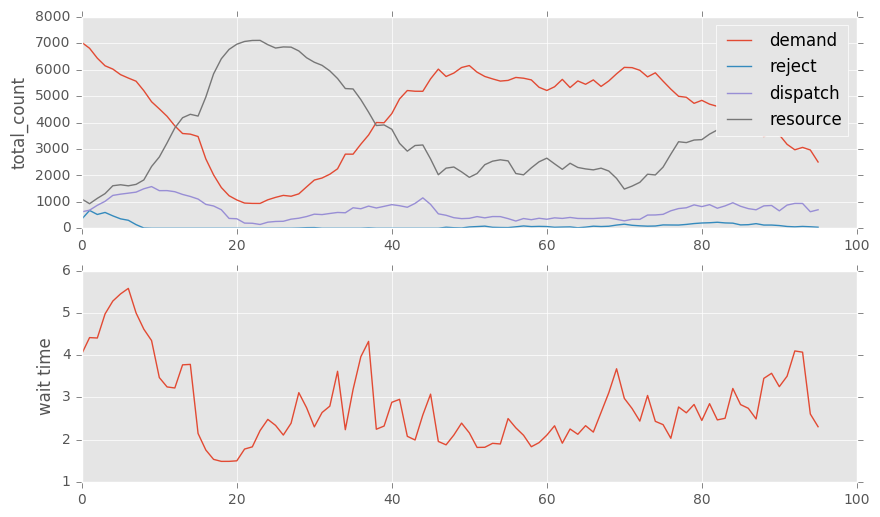

In [7]:
plot(score);

In [50]:
from keras.models import model_from_json

# load json and create model
with open('data/model/demand/model.json', 'r') as f:
    model = f.read()
model = model_from_json(model)
# load weights into new model
model.load_weights("data/model/demand/model.h5")

## CNN Demand Model

In [39]:
import Geohash

N = 219
lat0 = 40.6
lon0 = -74.041
dl = 0.3 / (N - 1)
lats = []
lons = []
for g in geohash_table.index:
    lat, lon, _, _  = Geohash.decode_exactly(g)
    lats.append(lat)
    lons.append(lon)
geohash_table['x'] = ((np.array(lons) - lon0) / dl).astype(np.uint8)
geohash_table['y'] = ((np.array(lats) - lat0) / dl).astype(np.uint8)

In [52]:
env.reset(NUM_FLEETS, trips, dayofweek, minofday)

agent = Agent(geohash_table, eta_table, pdest_table, model, CYCLE,
              T=3, cost=0, penalty=20.0)
for _ in range(NO_OP_STEPS):
    _, requests, _, _, _ = env.step()
agent.reset(requests, env.dayofweek, env.minofday)
score = ex.run(env, agent, num_steps, average_cycle=4)
ex.describe(score)

t = 60 (378 elapsed) // REQ: 26430 / REJ: 2204 / AWT: 4.5 / DSP: 0.39 / RWD: 74.7
t = 120 (703 elapsed) // REQ: 23090 / REJ: 1352 / AWT: 5.4 / DSP: 0.62 / RWD: 33.7
t = 180 (1002 elapsed) // REQ: 18750 / REJ: 13 / AWT: 4.2 / DSP: 0.70 / RWD: 26.3
t = 240 (1244 elapsed) // REQ: 14495 / REJ: 0 / AWT: 3.3 / DSP: 0.59 / RWD: 19.8
t = 300 (1399 elapsed) // REQ: 7418 / REJ: 0 / AWT: 1.6 / DSP: 0.26 / RWD: 9.4
t = 360 (1534 elapsed) // REQ: 3905 / REJ: 0 / AWT: 2.0 / DSP: 0.07 / RWD: 7.8
t = 420 (1695 elapsed) // REQ: 4701 / REJ: 7 / AWT: 2.6 / DSP: 0.11 / RWD: 9.0
t = 480 (1884 elapsed) // REQ: 6594 / REJ: 83 / AWT: 3.9 / DSP: 0.17 / RWD: 12.7
t = 540 (2136 elapsed) // REQ: 9905 / REJ: 51 / AWT: 4.2 / DSP: 0.26 / RWD: 18.7
t = 600 (2509 elapsed) // REQ: 14705 / REJ: 103 / AWT: 3.5 / DSP: 0.41 / RWD: 26.4
t = 660 (2856 elapsed) // REQ: 19635 / REJ: 0 / AWT: 2.3 / DSP: 0.48 / RWD: 35.0
t = 720 (3204 elapsed) // REQ: 22605 / REJ: 52 / AWT: 2.2 / DSP: 0.46 / RWD: 42.2
t = 780 (3424 elapsed) // R